# Spectral unmixing

Simulation - each fluorophore has an emission spectrum simulated by a center wavelength and a spectral half width.  
Represent all noise as shot-noise, so if N photons collected $\sqrt{N}$ noise.  

$$y_{ij} = \sum_{k=1}^M a_{ik}x_{kj}$$

$y_{ij}$ signal in spectral band $i$ at pixel $j$ is the sum across $M$ flurophores, each with emission coefficient $a_{ik}$ in spectral band $i$, and concentration $x_{kj}$ at pixel $j$  
Minimize negative log-likehood function.  
Can add L1 like regularization term to cost function.  

Can add an excitation coefficient for stimulating at different wavelengths too

$$y_{ijl} = \sum_{k=1}^M a_{ik}x_{kj}q_{kl}$$

where the exciation efficiency of dye $k$ at wavelength $l$ is $q_{kl}$.

In [39]:
0.6e9*1.2e-3/60/60/24

8.333333333333332

### signal to noise
From *Sheppard, C., Min Gu, Maitreyee Roy, C. Sheppard, Min Gu, and Maitreyee Roy. “Signal‐to‐noise Ratio in Confocal Microscope Systems.” Journal of Microscopy (January 3, 1992).*

$$SNR = \frac{\eta N_p}{\sqrt{\eta N_p + N_n^2}}$$

Where $\eta$ is the quantum efficiency, $N_p$ is the number of signal photons per pixel and $N_n$ is the sensor noise in electrons per pixel.

## image simulation

In [1]:
from numpy.random import poisson

In [6]:
def obs(number_photons, sensor_noise=0, quantum_efficency=0, size=1):
    return poisson(number_photons, size)

In [14]:
sim = obs(2000, size=10000)

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

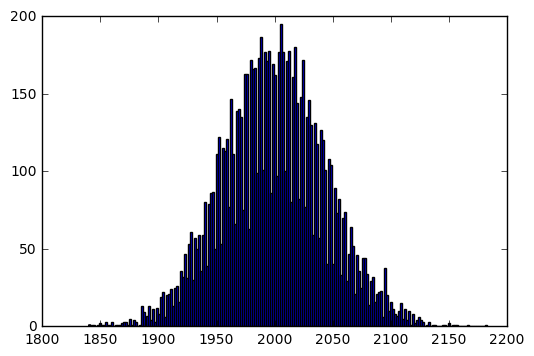

In [18]:
plt.hist(sim, bins=200);

In [17]:
img = random_noise(astronaut(), mode='poisson') 

NameError: name 'random_noise' is not defined

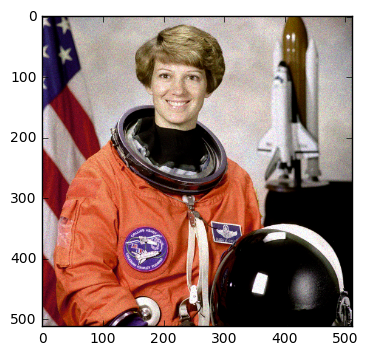

In [10]:
plt.imshow(img);

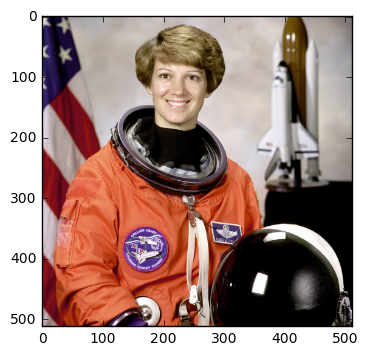

In [6]:
plt.imshow(astronaut())